\newpage

# Chapter 5: The Forecaster's Toolbox 

In [1]:
# data wrangling 
import pandas as pd 
import numpy as np

# data visuals
import matplotlib.pyplot as plt 
import seaborn as sns

# timeseries analysis
from darts import TimeSeries

# ts decomposition
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

# forecasting method
from darts.models import NaiveMean
from darts.models import NaiveSeasonal # K=1 for last value, K=4 for quarterly data
from darts.models import NaiveDrift

In [2]:
# | echo : false
pd.set_option('display.max_columns', 7)
plt.rcParams['figure.figsize'] = (10, 6)

## Exercise 1

Produce forecasts for the following series using whichever of NAIVE(y), SNAIVE(y) or RW(y ~ drift()) is more appropriate in each case:

* Australian Population (global_economy)

* Bricks (aus_production)

* NSW Lambs (aus_livestock)

* Household wealth (hh_budget).

* Australian takeaway food turnover (aus_retail).

In [57]:
# | warning : false

# reading in the data
df_global_economy = pd.read_csv("../rdata/global_economy.csv", parse_dates=['Year'])
df_production= pd.read_csv("../rdata/aus_production.csv", parse_dates=['Quarter'])
df_livestock = pd.read_csv("../rdata/aus_livestock.csv", parse_dates=['Month'])
df_budget = pd.read_csv("../rdata/hh_budget.csv", parse_dates=['Year'])
df_retail = pd.read_csv("../rdata/aus_retail.csv",parse_dates=['Month'])

C:\Users\nickc\AppData\Local\Temp\ipykernel_32136\2265436072.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_production= pd.read_csv("../rdata/aus_production.csv", parse_dates=['Quarter'])
C:\Users\nickc\AppData\Local\Temp\ipykernel_32136\2265436072.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_livestock = pd.read_csv("../rdata/aus_livestock.csv", parse_dates=['Month'])
C:\Users\nickc\AppData\Local\Temp\ipykernel_32136\2265436072.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_retail = pd.read_csv("../rdata/aus_retail.csv",parse_dates=['Month'])


### Australian Population from `global_economy` 

In [4]:
# filter australia
df_aus = df_global_economy.query('Country == "Australia"')

<Axes: xlabel='Year'>

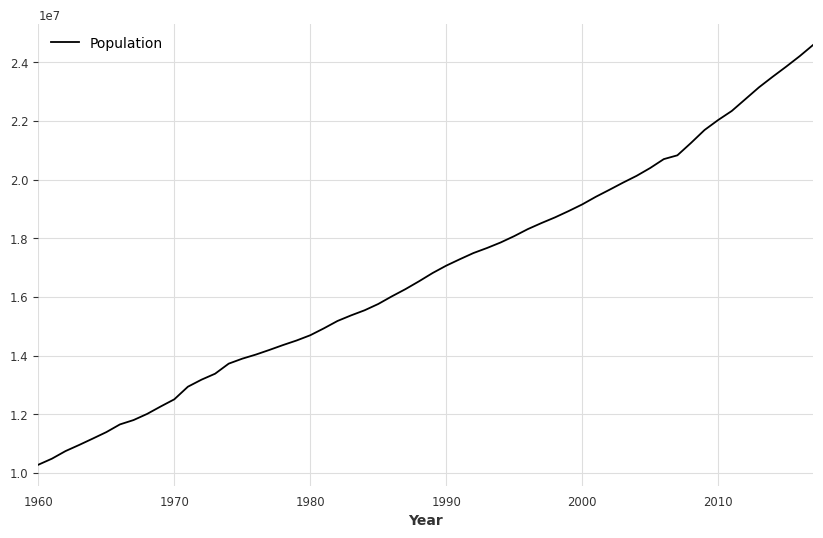

In [5]:
# plot australian timeseries pop
df_aus_pop = df_aus[['Year', 'Population']]
df_aus_pop.set_index('Year', inplace=True)
df_aus_pop.plot()


The Australian Populatiion has near perfect linear growth from the 1960 to 2020. Before, choosing which forecasting method to go with. I would like to see the decomposition of this time series just to make sure that my initial observation of no seasonality is correct.

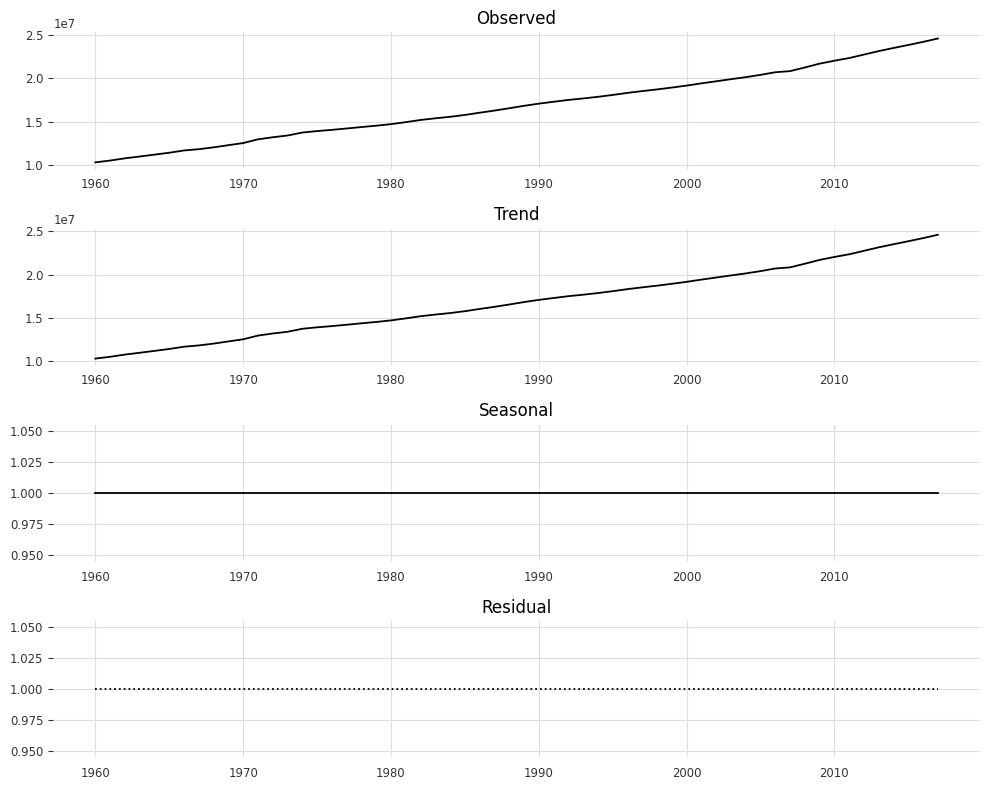

In [6]:
# decompose this ts 
decomposition = seasonal_decompose(df_aus_pop.Population, period = 1, model="multiplicative")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(decomposition.observed)
ax1.set_title('Observed')

ax2.plot(decomposition.trend)
ax2.set_title('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')

ax4.plot(decomposition.resid, linestyle = "dotted", markersize = 10)
ax4.set_title('Residual')

plt.tight_layout()
plt.show()

The trend line captures almost all of the observed data indicated that the seasonal component is constant at a value of 1. Thus, I believe that using the Drift method would be the most appropriate for this timeseries since it exhibits no seasonality and a overal upward trend. Wherein our forecast cast would be the average change seen in the data.

In [7]:
# convert df to ts 
series = TimeSeries.from_dataframe(df_aus,'Year', 'Population')


c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


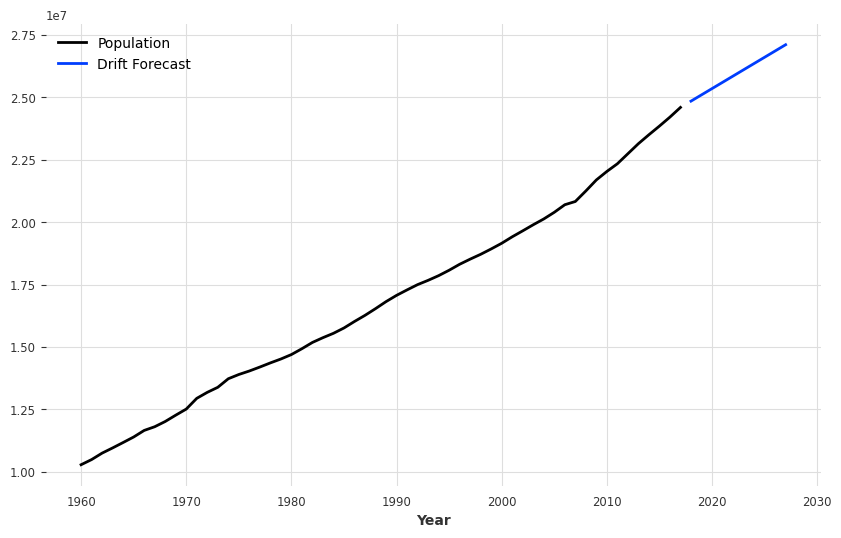

In [8]:
drift = NaiveDrift()

drift.fit(series)

forecast = drift.predict(10) # 10 timesteps
series.plot()
forecast.plot(label='Drift Forecast', low_quantile = 0.05, high_quantile=0.95)
plt.legend()

From the eye test, we observe that the Drift forecast is in-line with the data. It reasonable to agree with the forecast since the timeseries demonstrates an linear growth in population.

### Bricks from `aus_production`

In [9]:
df_bricks = df_production[['Quarter', 'Bricks']]

<Axes: xlabel='Quarter'>

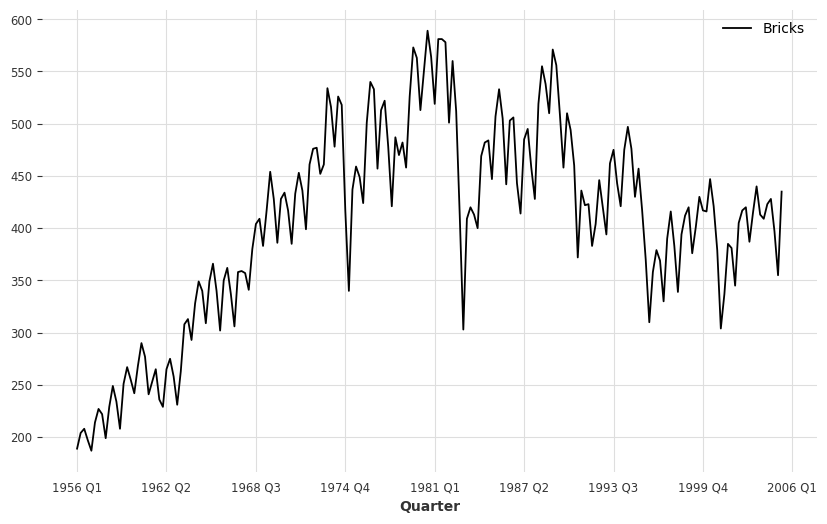

In [10]:
df_bricks.set_index('Quarter').plot()

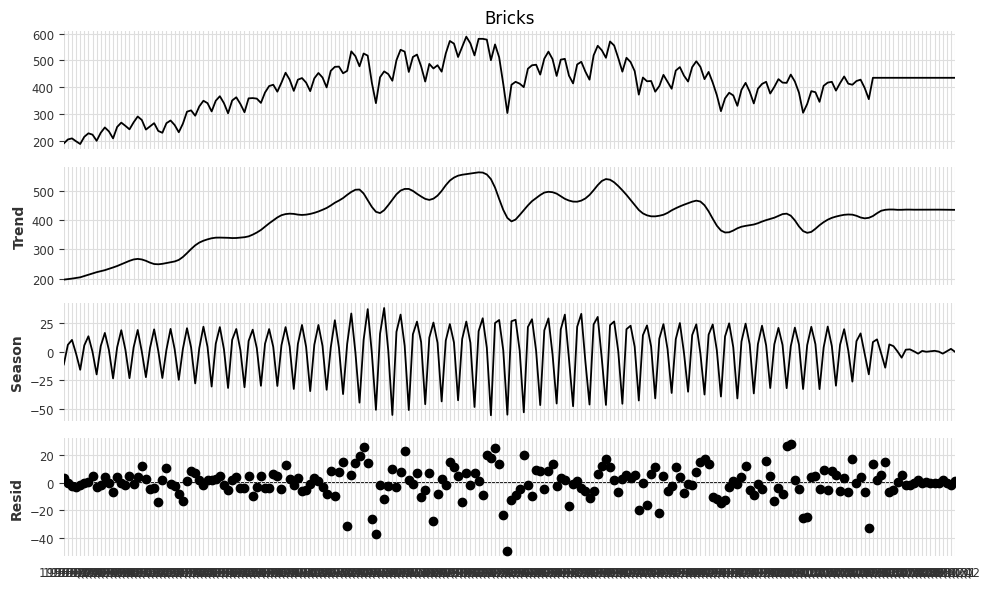

In [11]:
#| warning : false

bricks_plot = df_bricks.set_index('Quarter')
bricks_plot['Bricks'] = bricks_plot['Bricks'].ffill()

decom = STL(bricks_plot['Bricks'], period = 4).fit()
decom.plot()
plt.show()

We see a high frequency of the seasonality component while it is unclear whether the trend line is increasing or decreasing. Thus, we believe that using the seasonal naive would be best for forecasting this particular time series. 

In [12]:
df_bricks = df_bricks.dropna() # missing a data at the tail() 

# format datetime to accomodate the input for darts library
df_bricks['Quarter'] = pd.to_datetime(df_bricks['Quarter'].astype(str), format='%Y Q%m')

df_bricks.set_index('Quarter')

,Bricks
Quarter,
1956-01-01,189.0
1956-02-01,204.0
1956-03-01,208.0
1956-04-01,197.0
1957-01-01,187.0
...,...
2004-02-01,423.0
2004-03-01,428.0
2004-04-01,397.0


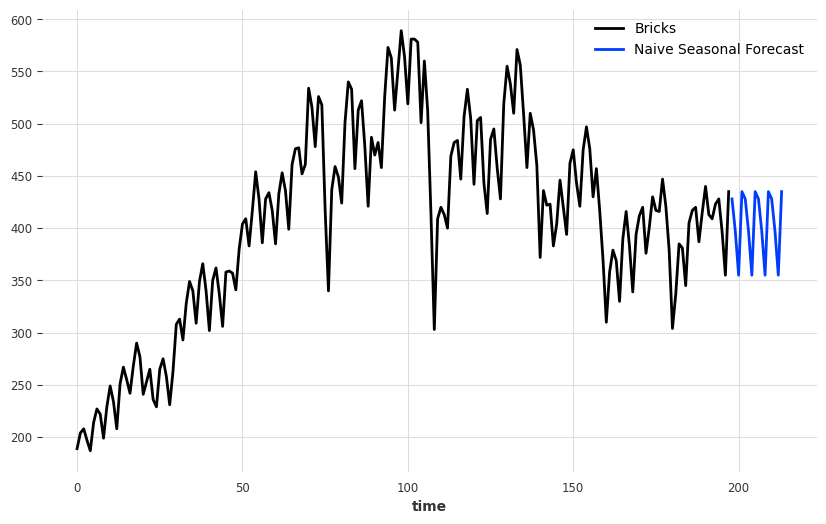

In [13]:
# remove time col since it is set as the index
series = TimeSeries.from_dataframe(df_bricks, value_cols='Bricks', fill_missing_dates=True)

seasonal = NaiveSeasonal(K=4) # K=4 for quarterly data

seasonal.fit(series)

forecast = seasonal.predict(16)

series.plot()
forecast.plot(label='Naive Seasonal Forecast')
plt.legend()

### NSW Lambs from `aus_livestock`

In [14]:
display(df_livestock.State.unique())
display(df_livestock.Animal.unique())

array(['Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia'], dtype=object)

array(['Bulls, bullocks and steers', 'Calves', 'Cattle (excl. calves)',
       'Cows and heifers', 'Lambs', 'Pigs', 'Sheep'], dtype=object)

Assuming NSW means New South Wales. So, we need to filter `df_livestock` of sheep from New South Wales.

In [15]:
df_sheep = df_livestock.query('Animal == "Sheep" & State == "New South Wales"')
df_sheep

,Unnamed: 0,Month,Animal,State,Count
25458,25459,1972-07-01,Sheep,New South Wales,669400.0
25459,25460,1972-08-01,Sheep,New South Wales,581100.0
25460,25461,1972-09-01,Sheep,New South Wales,468100.0
25461,25462,1972-10-01,Sheep,New South Wales,515300.0
25462,25463,1972-11-01,Sheep,New South Wales,564500.0
...,...,...,...,...,...
26011,26012,2018-08-01,Sheep,New South Wales,245900.0
26012,26013,2018-09-01,Sheep,New South Wales,236800.0
26013,26014,2018-10-01,Sheep,New South Wales,277200.0
26014,26015,2018-11-01,Sheep,New South Wales,263600.0


Next, we want to see the timeseries.

<Axes: xlabel='Month'>

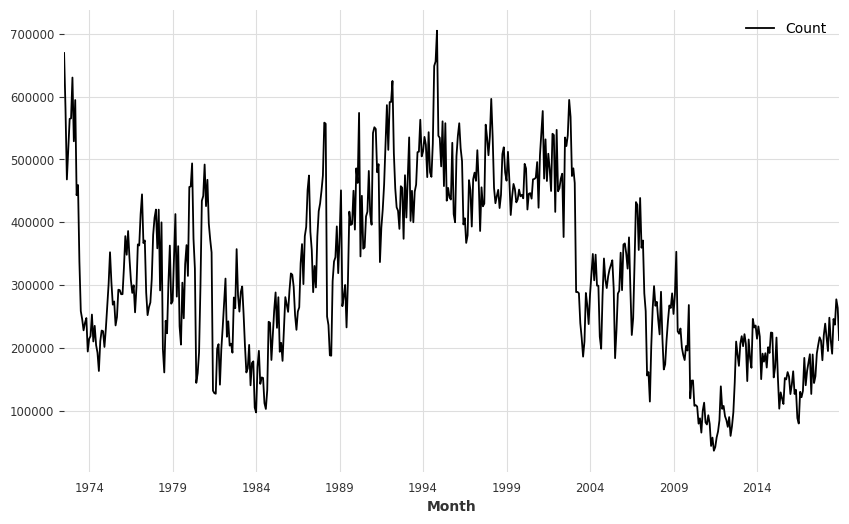

In [16]:
df_sheep[['Month', 'Count']].set_index(['Month']).plot()


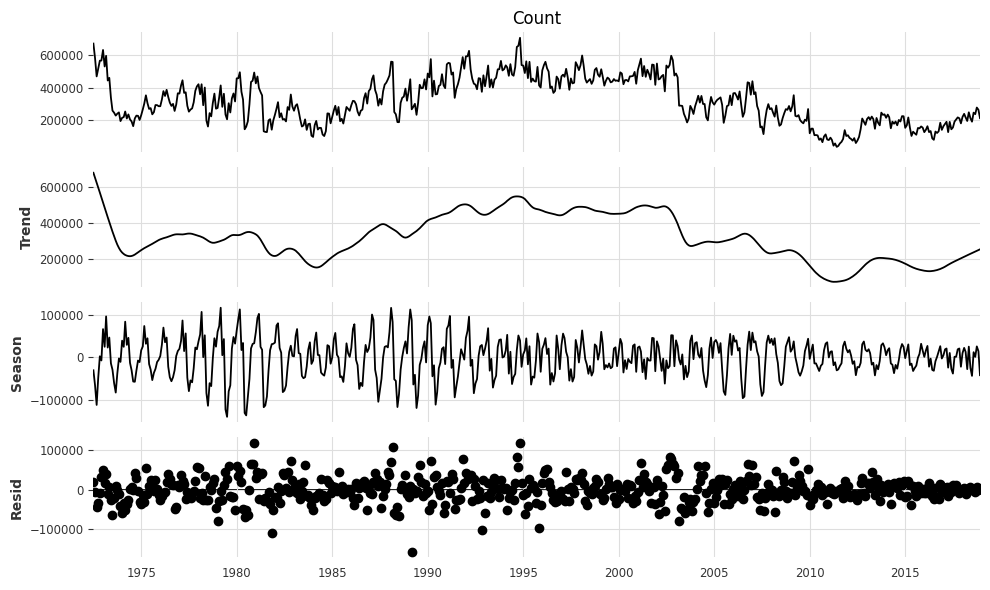

In [17]:
sheep = df_sheep.set_index('Month')
decomposition = STL(sheep['Count']).fit()
decomposition.plot()
plt.show()

We see that this time seres has no clear trend and inconsistent seasonality component which suggest that we use the Mean Naive method.

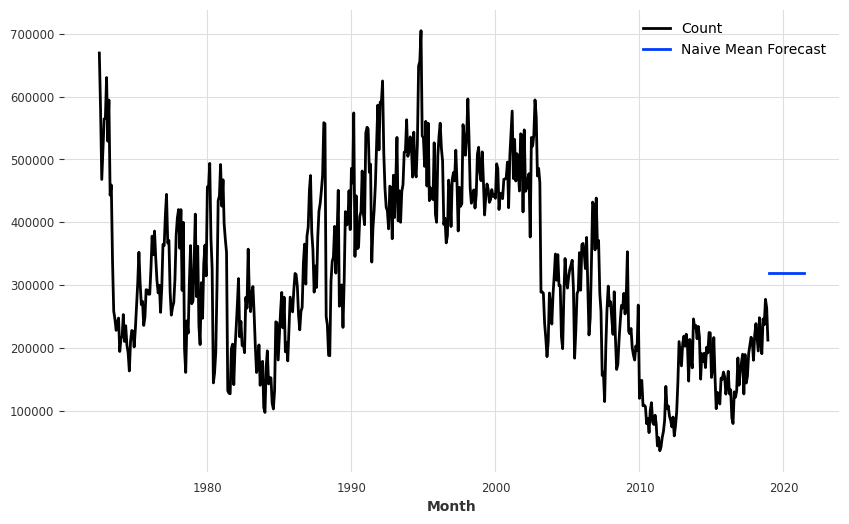

In [18]:
series = TimeSeries.from_dataframe(df_sheep, 'Month', 'Count')

model = NaiveMean() 
model.fit(series)
forecast = model.predict(30) # 30 timesteps in the future in this case 30 months

series.plot()
forecast.plot(label = 'Naive Mean Forecast')
plt.legend()

### Household Wealth from `hh_budget`

Let us see which columns and constrains we need to filter. We will need the `Year`, `Country` and `Wealth` columns. 

In [27]:
df_wealth = df_budget[['Year', 'Country', 'Wealth']]
df_wealth

,Year,Country,Wealth
0,1995-01-01,Australia,314.9344
1,1996-01-01,Australia,314.5559
2,1997-01-01,Australia,323.2357
3,1998-01-01,Australia,339.3139
4,1999-01-01,Australia,354.4382
...,...,...,...
83,2012-01-01,USA,514.4276
84,2013-01-01,USA,592.3568
85,2014-01-01,USA,596.4713
86,2015-01-01,USA,588.1454


So, we have annual data for wealth of four different countries. Based on the prior exercise, we can assume that we want the Australian data. 

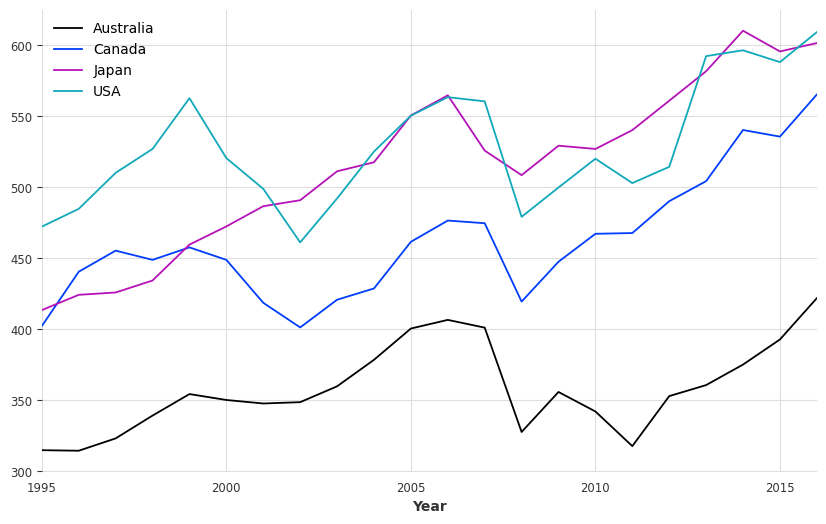

In [29]:
wealth = df_wealth
wealth = wealth.set_index(['Year'])

wealth.groupby('Country')['Wealth'].plot()
plt.legend()

In [41]:
aus_wealth = wealth.query('Country == "Australia"')

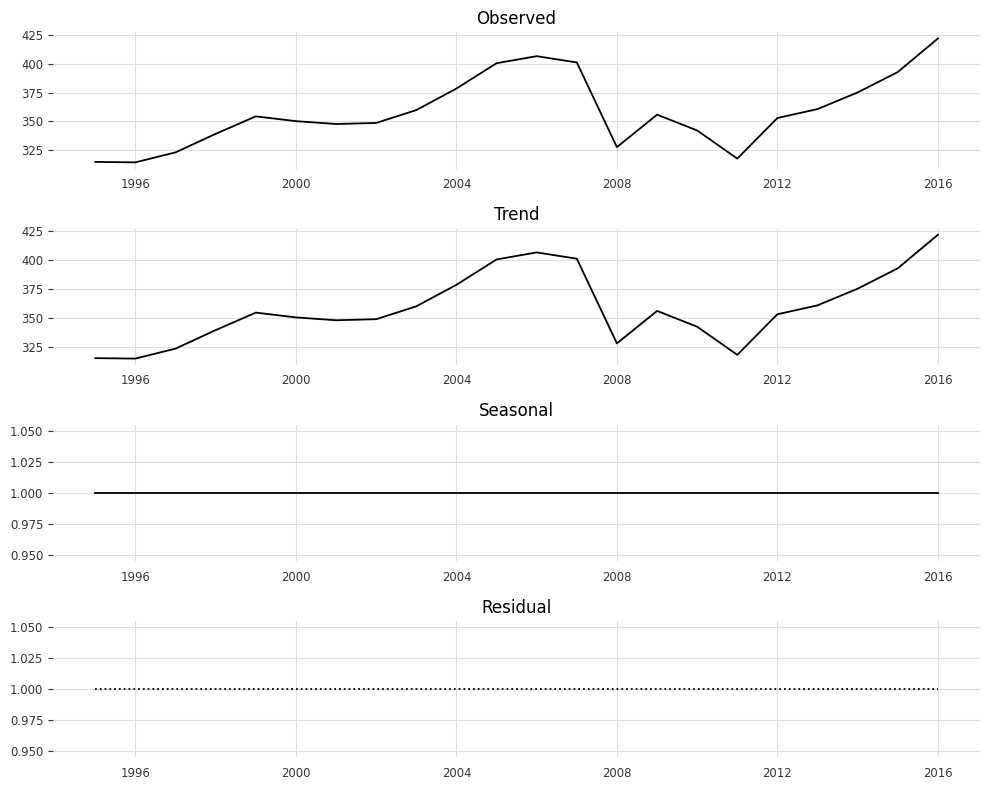

In [48]:
decomposition=seasonal_decompose(aus_wealth.Wealth, period=1,model="multiplicative")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(decomposition.observed)
ax1.set_title('Observed')

ax2.plot(decomposition.trend)
ax2.set_title('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')

ax4.plot(decomposition.resid, linestyle = "dotted", markersize = 10)
ax4.set_title('Residual')

plt.tight_layout()
plt.show()


From the decomposition, it clear that there is minimal seasonality and the trend line is unclear without further analysis. Thus, we believe using Naive Mean forecast would be the best for this time series.

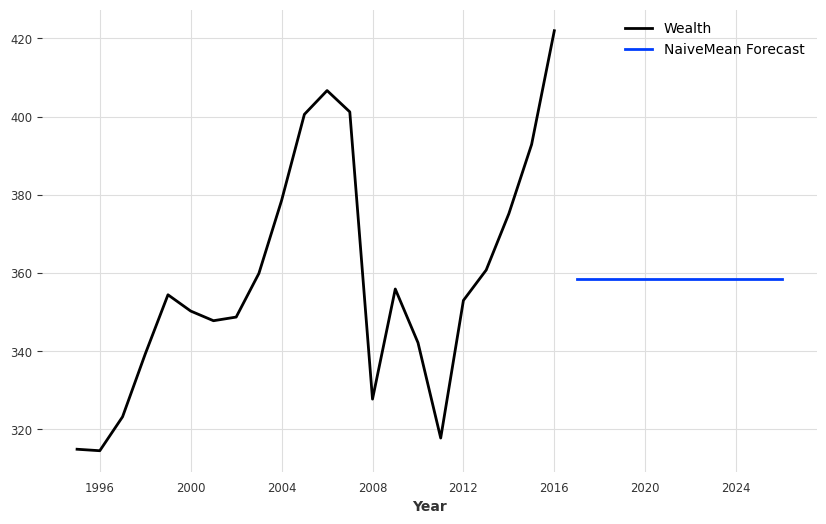

In [51]:
series = TimeSeries.from_dataframe(aus_wealth, value_cols='Wealth')

model = NaiveMean()

model.fit(series)

forecast = model.predict(10)

series.plot()
forecast.plot(label='NaiveMean Forecast')
plt.legend()

### Australian takeaway food turnover from `aus_retail`

In [64]:
df_takeaway = df_retail.query('Industry == "Takeaway food services"')
df_takeaway = df_takeaway[['Month', 'Turnover']]
df_takeaway.set_index('Month', inplace=True)
df_takeaway

,Turnover
Month,
1982-04-01,3.2
1982-05-01,3.3
1982-06-01,3.5
1982-07-01,3.5
1982-08-01,3.7
...,...
2018-08-01,178.5
2018-09-01,179.8
2018-10-01,183.2


<Axes: xlabel='Month'>

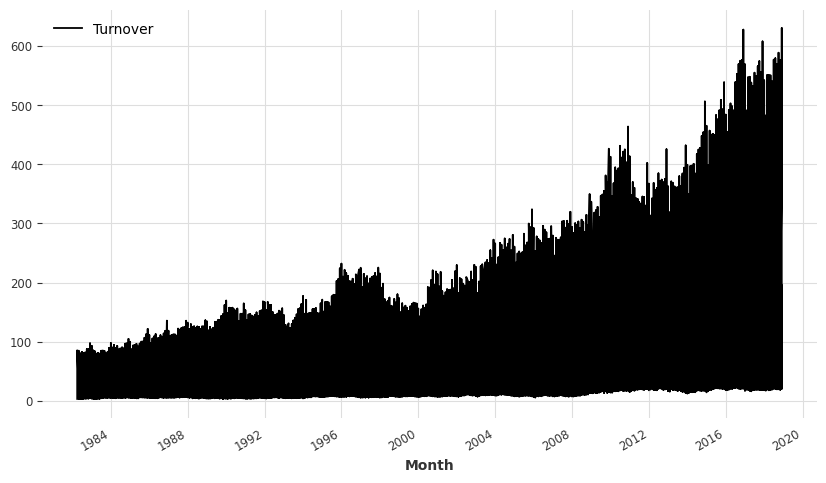

In [65]:
df_takeaway.plot()


## Exercise 2

Use the Facebook stock price (data set gafa_stock) to do the following:

* Produce a time plot of the series.

* Produce forecasts using the drift method and plot them.

* Show that the forecasts are identical to extending the line drawn between the first and last observations.

* Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?

## Exercise 3

 Apply a seasonal naïve method to the quarterly Australian beer production data from 1992. Check if the residuals look like white noise, and plot the forecasts. The following code will help.

```{r}
# Extract data of interest
recent_production <- aus_production |>
  filter(year(Quarter) >= 1992)

# Define and estimate a model
fit <- recent_production |> model(SNAIVE(Beer))
#Look at the residuals

fit |> gg_tsresiduals()

# Look a some forecasts
fit |> forecast() |> autoplot(recent_production)
```
What do you conclude?

## Exercise 4

Repeat the previous exercise using the Australian Exports series from global_economy and the Bricks series from aus_production. Use whichever of NAIVE() or SNAIVE() is more appropriate in each case

## Exercise 7

 For your retail time series (from Exercise 7 in Section 2.10):

a. Create a training dataset consisting of observations before 2011 using

```{r}
myseries_train <- myseries |>
  filter(year(Month) < 2011)
```

b. Check that your data have been split appropriately by producing the following plot.

```{r}
autoplot(myseries, Turnover) +
  autolayer(myseries_train, Turnover, colour = "red")
```
c. Fit a seasonal naïve model using SNAIVE() applied to your training data (myseries_train).
```{r}
fit <- myseries_train |>
  model(SNAIVE())
```
d. Check the residuals.
```{r}
fit |> gg_tsresiduals()
```
Do the residuals appear to be uncorrelated and normally distributed?

e.Produce forecasts for the test data

```{r}
fc <- fit |>
  forecast(new_data = anti_join(myseries, myseries_train))
fc |> autoplot(myseries)
```
f. Compare the accuracy of your forecasts against the actual values.

```{r}
fit |> accuracy()
fc |> accuracy(myseries)
```

g.How sensitive are the accuracy measures to the amount of training data used?